### Import libraries and data

In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
# pip install geopandas
import geopandas as gpd
from shapely.geometry import Polygon
import os
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
import pyproj
from shapely.ops import transform
from functools import partial


parent_directory = os.path.dirname(os.getcwd())
bike_file_path = parent_directory + '/data/Existing_Bike_Network_2023.geojson'

bike_lanes = gpd.read_file(bike_file_path)
bike_lanes['year'] = pd.to_numeric(bike_lanes['InstallDat'], errors = 'coerce').astype('Int64')

blocks_file_path = parent_directory + '/data/census2020_blockgroups.json'
blocks = gpd.read_file(blocks_file_path)

#### format polygons + group into tracts

In [52]:
# convert block polygons to LatLong 

# Define the UTM projection for Zone 19T (for Boston, MA)
state_plane = pyproj.Proj(init='epsg:2249', preserve_units=True)

# Define a function to convert UTM coordinates to latitude and longitude
def utm_to_latlon(x, y):
    lon, lat = state_plane(x, y, inverse=True)
    return lon, lat

# Define a function to transform coordinates to UTM and then to latitude and longitude
def transform_to_latlon(geom):
    transformed_geom = transform(partial(pyproj.transform, state_plane, pyproj.Proj(init='epsg:4326')), geom)
    return transformed_geom

for i, row in blocks.iterrows():
    poly = row['geometry']
    # Check if the geometry is a MultiPolygon
    if poly.geom_type == 'MultiPolygon':
        # If it's a MultiPolygon, iterate through individual polygons
        polygon_latlon = []
        for single_poly in poly.geoms:
            for ring in single_poly.exterior.coords:
                lat, lon = utm_to_latlon(ring[0], ring[1])
                polygon_latlon.append((lat, lon))
        formatted_polygon = MultiPolygon([Polygon(polygon_latlon)])
    else:
        polygon_latlon = []
        for ring in poly.exterior.coords:
            lat, lon = utm_to_latlon(ring[0], ring[1])
            polygon_latlon.append((lat, lon))
        formatted_polygon = Polygon(polygon_latlon)
    
    blocks.at[i, 'formatted_polygon'] = formatted_polygon

c:\Users\Raviv\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


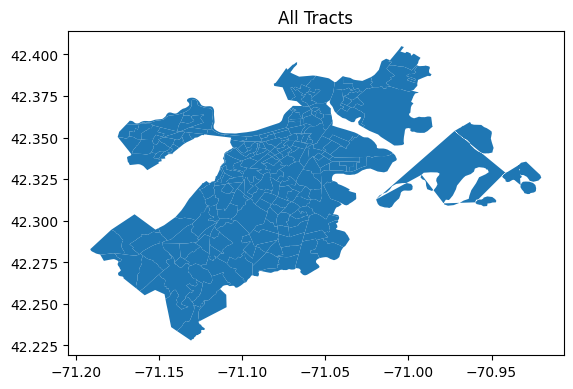

In [105]:
from shapely.ops import unary_union
grouped_tracts = blocks.groupby('TRACTCE20')['formatted_polygon'].apply(unary_union).reset_index()
tracts_gdf = gpd.GeoDataFrame(grouped_tracts, geometry='formatted_polygon')

# Plot the polygons
tracts_gdf.plot()
plt.title('All Tracts')
plt.show()

In [255]:
# define circle for each tract: centroid point + defined radius
import math

RADIUS = 1 # in km

def km_to_degrees(km, latitude):
    # Radius of the Earth in meters
    earth_radius = 6378137.0

    # Calculate the circumference of the Earth at given latitude
    circumference = 2 * math.pi * earth_radius * math.cos(math.radians(latitude))

    # Convert meters to degrees of longitude
    degrees_per_meter = 360.0 / circumference
    degrees = km *1000 * degrees_per_meter

    return degrees

for i, row in grouped_tracts.iterrows():
    # Find the center point (centroid) of the combined polygon
    center_point = row['formatted_polygon'].centroid
    lat = center_point.y
    # Define radius of the circle
    radius_km = RADIUS  # Change this value to set the radius of the circle
    radius_deg = km_to_degrees(radius_km, lat)
    # Create a circle around the center point with the specified radius
    circle = Point(center_point).buffer(radius_deg)
    grouped_tracts.at[i, 'circle'] = circle

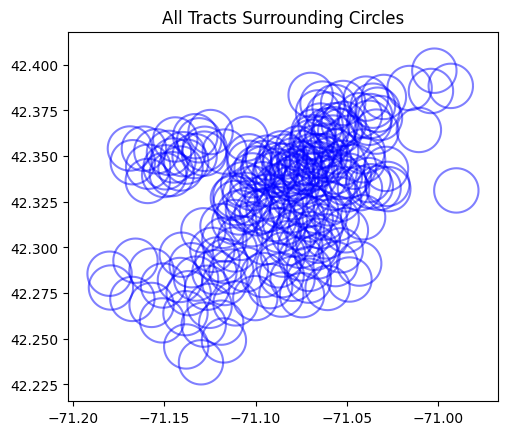

In [256]:
tracts_gdf = gpd.GeoDataFrame(grouped_tracts, geometry='circle')

# Plot the polygons
tracts_gdf.plot(facecolor='none', edgecolor='blue', linewidth=1.5, alpha=0.5)
plt.title('All Tracts Surrounding Circles')
plt.show()

In [ ]:
#define bike lane dictionary
infra_dict = {'BFBL' : 'Buffered bike lane',
'BL' : 'Bike lane',
'BLSL' : 'Bike lane on one side, shared lane on the opposite side',
'BSBL' : 'Bus/bike lane',
'CFBL' : 'Contra-flow bike street',
'NSUP' : 'Shared use path, natural surface',
'NW' : 'Neighborway, marked',
'NW-U' : 'Neighborway, unmarked',
'SBL' : 'Separated bike lane',
'SBLBL' : 'Separated bike lane on one side, bike lane on the opposite side',
'SLM' : 'Shared lane markings',
'SLMTC' : 'Shared lane markings, Traffic calmed street',
'SRd' : 'Shared road',
'SUB' : 'Shared use path bridge',
'SUC' : 'Shared use connector',
'SUP' : 'Shared use path',
'TC' : 'Traffic calmed street',
}
bike_lanes['ExisFacil'].replace(infra_dict, inplace=True) # remove later

### Gathering Tabular Data by Neighborhood 

##### Dorchester

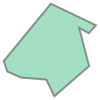

In [257]:
# polygon of coords, from google maps
pol = [(42.29206533274252, -71.09562722715653), (42.33090986566151, -71.06369820984568), (42.316314241773526, -71.03314248394966), (42.31085587795951, -71.03794900269062), (42.314537152039506, -71.04447213526767),
(42.28863672310401, -71.03777734130702), (42.268188176048305, -71.06129495080786), (42.27949285134003, -71.06678811508326), (42.28088991760289, -71.0841259148275), (42.28495393424176, -71.09322396815864), (42.29206533274252, -71.09562722715653)]
dorchester_coords = [(y,x) for (x,y) in pol]
Polygon(dorchester_coords)

In [258]:
# Define the coordinates of the polygon (clockwise or counterclockwise order)
# Repeat the first point to close the polygon
# coords are written (long, lat), reversed from map data

# Create a Polygon object from the coordinates
dorchester_poly = Polygon(dorchester_coords)
dorchester_bike = bike_lanes[bike_lanes.geometry.within(dorchester_poly)]

In [259]:
dorchester_bike.head(1)

,FID,STREET_NAM,ROADINVENT,FUNCTIONAL,JURISDICTI,Divided,InstallDat,ExisFacil,Shape_Leng,Shape__Length,geometry,year
134,135,Blue Hill Avenue,6212800,3,2,1,2010,BL,60.76522,60.76522,"LINESTRING (-71.09093 42.28610, -71.09111 42.2...",2010


C:\Users\Raviv\AppData\Local\Temp\ipykernel_5716\2937214844.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


Text(0.5, 1.0, 'Tracts + surrounding areas: Dorchester')

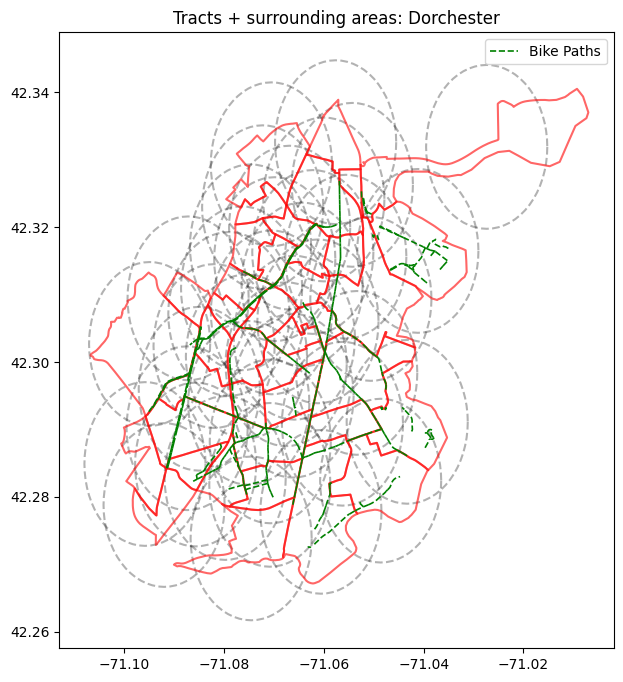

In [328]:
dorchester_tracts = grouped_tracts[grouped_tracts['formatted_polygon'].apply(lambda polygon: polygon.intersects(dorchester_poly))]

# Create a new figure and axis
fig, ax = plt.subplots(figsize = (16,8))
dorch_circle = gpd.GeoDataFrame(dorchester_tracts, geometry='circle')
dorch_circle['circle'].plot(ax=ax, color='none', edgecolor='black', linestyle='dashed', linewidth=1.5, alpha=0.3, label = 'Tract "Bike Lane Relevance" Area ')

dorch_poly = gpd.GeoDataFrame(dorchester_tracts, geometry='formatted_polygon')
dorch_poly['formatted_polygon'].plot(ax=ax, color='none', edgecolor='r',  linewidth=1.5, alpha=0.6, label = "Tract Borders")

dorch_bike_lanes = gpd.GeoDataFrame(dorchester_bike, geometry='geometry')
dorch_bike_lanes['geometry'].plot(ax=ax, color='g', linestyle='dashed', linewidth=1.2, label = "Bike Paths")

ax.legend()
plt.title('Tracts + surrounding areas: Dorchester')

In [376]:
# create a long-format df of all bike lanes in Dorchester, by tract
joined_dorch = gpd.sjoin(dorch_circle, dorch_bike_lanes, how='left', op='intersects')
grouped_dorch = joined_dorch.groupby(['TRACTCE20', 'year','ExisFacil']).agg({
    'Shape_Leng': 'sum',
}).reset_index()
dorch_pivot = pd.pivot_table(grouped_dorch, index=['TRACTCE20', 'year'], columns='ExisFacil', values='Shape_Leng', aggfunc='sum', fill_value=0).reset_index()
dorch_pivot['total_built'] = dorch_pivot[['BFBL', 'BL', 'BLSL', 'SBL', 'SLM', 'SUP']].sum(axis=1)
dorch_pivot.rename(columns={'ExisFacil':'index'},inplace=True)

C:\Users\Raviv\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Raviv\AppData\Local\Temp\ipykernel_5716\211957667.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_dorch = gpd.sjoin(dorch_circle, dorch_bike_lanes, how='left', op='intersects')


#### plots

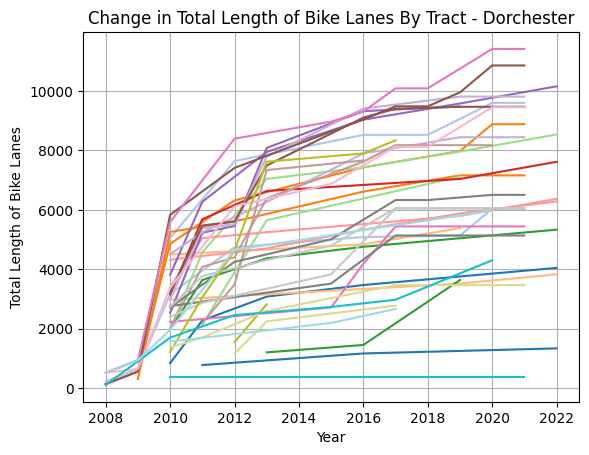

In [380]:
import matplotlib.pyplot as plt
dorch_pivot_sorted = dorch_pivot.sort_values(by=['TRACTCE20', 'year']) #sorting by year to sum cummulatively

dorch_pivot_sorted['cumulative_length'] = dorch_pivot_sorted.groupby('TRACTCE20')['total_built'].cumsum(axis=0)

# Assuming dorch_pivot contains the data with columns 'polygon_id', 'year', and total lengths of bike lanes
unique_polygon_ids = dorch_pivot_sorted['TRACTCE20'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_polygon_ids)))

# Iterate through unique polygon IDs and plot a line for each polygon
for i, polygon_id in enumerate(dorch_pivot_sorted['TRACTCE20'].unique()):
    polygon_data = dorch_pivot_sorted[dorch_pivot_sorted['TRACTCE20'] == polygon_id]
    plt.plot(polygon_data['year'], polygon_data['cumulative_length'], label=f'Polygon ID {polygon_id}', color=colors[i])

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Total Length of Bike Lanes')
plt.title('Change in Total Length of Bike Lanes By Tract - Dorchester')
# plt.legend(loc='best')  # Display legend for the lines
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot


In [269]:
# Streets with most bike lanes
street_df = dorchester_bike.loc[dorchester_bike['STREET_NAM']!=' ']
total_length_df = street_df.groupby(['STREET_NAM'])['Shape_Leng'].sum().reset_index()
total_length_df.rename(columns={'Shape_Leng': 'Total_Length'}, inplace=True)
total_length_df.sort_values(by='Total_Length',ascending=False,inplace=True)
top_5_streets = total_length_df.head(5)
top_5_streets.STREET_NAM.to_list()

['Columbia Road',
 'Dorchester Avenue',
 'Blue Hill Avenue',
 'Adams Street',
 'Talbot Avenue']

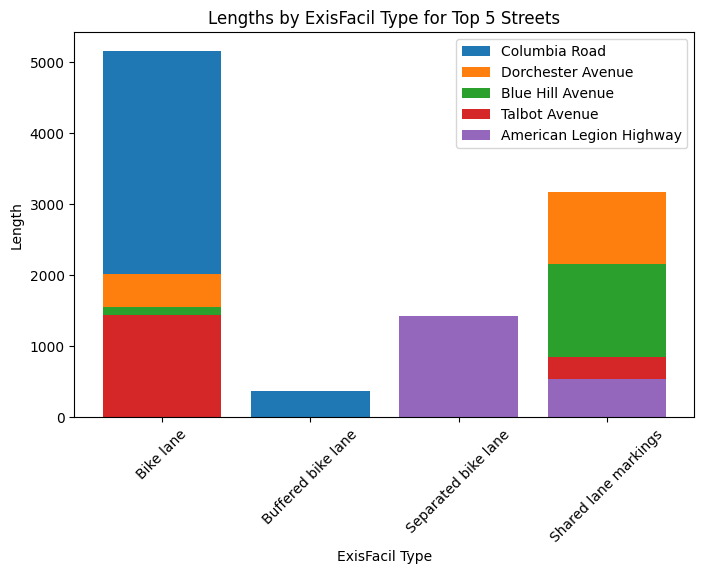

In [9]:
# length by street, for each facility type

data_dict = {}

for street in top_5_streets['STREET_NAM']:
    street_data = street_df.loc[street_df['STREET_NAM'] == street]
    lengths_by_type = street_data.groupby('ExisFacil')['Shape_Leng'].sum().reset_index()
    data_dict[street] = dict(zip(lengths_by_type['ExisFacil'], lengths_by_type['Shape_Leng']))

# Create a single plot with each street on the x-axis and different facility types as bars
plt.figure(figsize=(8, 5))
for street, data in data_dict.items():
    plt.bar(data.keys(), data.values(), label=street)

plt.xlabel('ExisFacil Type')
plt.ylabel('Length')
plt.title('Lengths by ExisFacil Type for Top 5 Streets')
plt.xticks(rotation=45)
plt.legend()
plt.show()


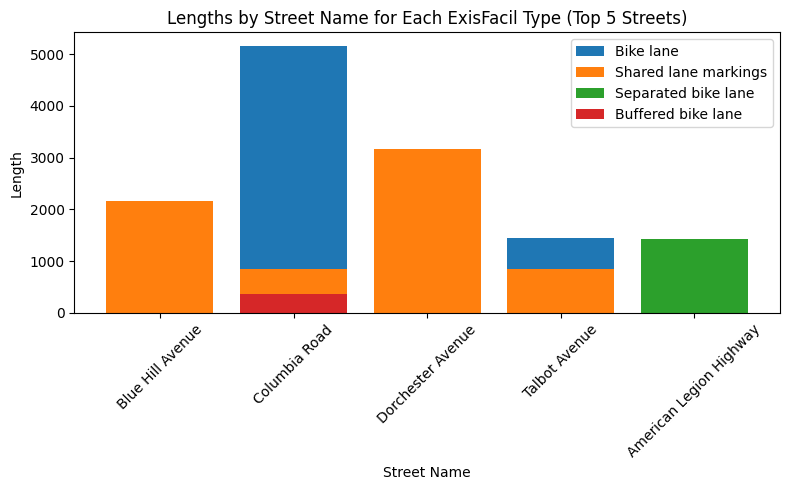

In [10]:
# length by facility type, for each street
data_dict = {}
color_dict = {}
# Populate the dictionary with lengths by Street name for each facility type for the top 5 streets
for facility_type in street_df['ExisFacil'].unique():
    facility_data = street_df.loc[(street_df['ExisFacil'] == facility_type) & (street_df['STREET_NAM'].isin(top_5_streets['STREET_NAM'].tolist()))]
    lengths_by_street = facility_data.groupby('STREET_NAM')['Shape_Leng'].sum().reset_index()
    data_dict[facility_type] = dict(zip(lengths_by_street['STREET_NAM'], lengths_by_street['Shape_Leng']))

unique_facility_types = data_dict.keys()
plt.figure(figsize=(8, 5))
for facility_type, data in data_dict.items():
    # color = color_dict[facility_type]  # Get color for the current facility type
    if data:
        plt.bar(data.keys(), data.values(), label=facility_type)

plt.xlabel('Street Name')
plt.ylabel('Length')
plt.title('Lengths by Street Name for Each ExisFacil Type (Top 5 Streets)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

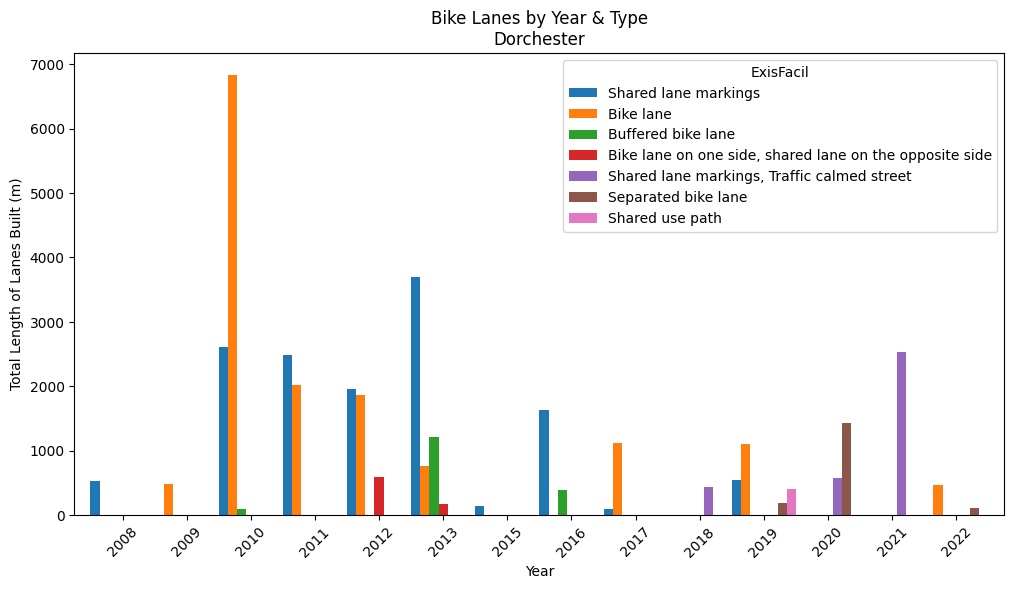

In [11]:
# total m of lanes by year and type
yealy_new_lanes = dorchester_gdf.groupby(['year', 'ExisFacil'])['Shape_Leng'].sum().unstack()
fig, ax = plt.subplots(figsize=(12, 6))
yealy_new_lanes.plot(kind='bar', ax=ax, align='center', width=1)
ax.set_xlabel('Year')
ax.set_ylabel('Total Length of Lanes Built (m)')
ax.set_title('Bike Lanes by Year & Type\nDorchester')
ax.tick_params(axis='x', rotation=45)
plt.show()

### Roxbury

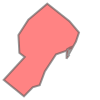

In [303]:
# polygon of coords, from google maps
rox_pol = [ (42.341608986056364, -71.08347172986149), (42.332253161966605, -71.07163155541365), (42.32621640774964, -71.06652803194476), (42.32138658725103, -71.0681611594548), (42.312258378390375, -71.07328003461689), (42.31782332073722, -71.07194482240432), (42.317195045437295, -71.07303726876006), (42.31890034951496, -71.06969923822862), 
       (42.31777709985751, -71.07181554914962), (42.31708331734832, -71.07300643204704), (42.31377440323021, -71.07315078148915), (42.31369434663409, -71.0721764227563), (42.31225331169338, -71.07325904357214), (42.31746430704819, -71.07048822726333), (42.3145482776965, -71.07881649709346),
       (42.30547247542557, -71.08476560337425), (42.29823831376148, -71.08747275766547), (42.298224610072566, -71.08712011436275), (42.297016652611624, -71.09120293313788), (42.292184591055154, -71.09589817472924), (42.300942429638944, -71.10671764448331),
       (42.313171166004146, -71.09548989285175), (42.315360010547955, -71.09834786558292), (42.324869276831514, -71.0988582179298), (42.33309438760423, -71.0935505536844), (42.341608986056364, -71.08347172986149)]

roxbury_coords = [(y,x) for (x,y) in rox_pol]
Polygon(roxbury_coords)

In [304]:
# Define the coordinates of the polygon (clockwise or counterclockwise order)
# Repeat the first point to close the polygon
# coords are written (long, lat), reversed from map data

# Create a Polygon object from the coordinates
roxbury_poly = Polygon(roxbury_coords)
roxbury_bike = bike_lanes[bike_lanes.geometry.within(roxbury_poly)]

In [308]:
roxbury_bike.head(1)

,FID,STREET_NAM,ROADINVENT,FUNCTIONAL,JURISDICTI,Divided,InstallDat,ExisFacil,Shape_Leng,Shape__Length,geometry,year
90,91,Jewish War Veterans Drive,5190500,5,2,0,2009,BL,577.676677,577.676677,"LINESTRING (-71.09388 42.30524, -71.09376 42.3...",2009


C:\Users\Raviv\AppData\Local\Temp\ipykernel_5716\3428789066.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


Text(0.5, 1.0, 'Tracts + surrounding areas: Roxbury')

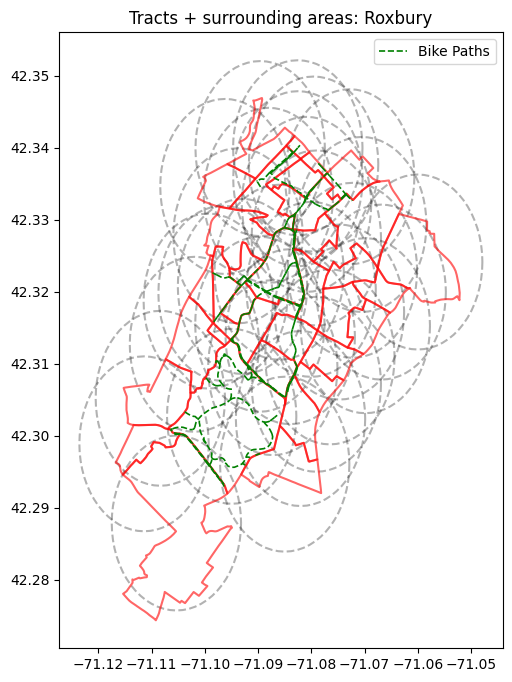

In [310]:
roxbury_tracts = grouped_tracts[grouped_tracts['formatted_polygon'].apply(lambda polygon: polygon.intersects(roxbury_poly))]

# Create a new figure and axis
fig, ax = plt.subplots(figsize = (16,8))
rox_circle = gpd.GeoDataFrame(roxbury_tracts, geometry='circle')
rox_circle['circle'].plot(ax=ax, color='none', edgecolor='black', linestyle='dashed', linewidth=1.5, alpha=0.3, label = 'Tract "Bike Lane Relevance" Area ')

rox_poly = gpd.GeoDataFrame(roxbury_tracts, geometry='formatted_polygon')
rox_poly['formatted_polygon'].plot(ax=ax, color='none', edgecolor='r',  linewidth=1.5, alpha=0.6, label = "Tract Borders")

rox_bike_lanes = gpd.GeoDataFrame(roxbury_bike, geometry='geometry')
rox_bike_lanes['geometry'].plot(ax=ax, color='g', linestyle='dashed', linewidth=1.2, label = "Bike Paths")

ax.legend()
plt.title('Tracts + surrounding areas: Roxbury')

In [377]:
# create a long-format df of all bike lanes in Roxbury, by tract
joined_rox = gpd.sjoin(rox_circle, rox_bike_lanes, how='left', op='intersects')
grouped_rox = joined_rox.groupby(['TRACTCE20', 'year','ExisFacil']).agg({
    'Shape_Leng': 'sum',
}).reset_index()
rox_pivot = pd.pivot_table(grouped_rox, index=['TRACTCE20', 'year'], columns='ExisFacil', values='Shape_Leng', aggfunc='sum', fill_value=0).reset_index()
rox_pivot['total_built'] = rox_pivot[['BFBL','BL','BLSL','SBL','SLM','SUP']].sum(axis=1)
rox_pivot.rename(columns={'ExisFacil':'index'}, inplace=True)


C:\Users\Raviv\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Raviv\AppData\Local\Temp\ipykernel_5716\2468572518.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_rox = gpd.sjoin(rox_circle, rox_bike_lanes, how='left', op='intersects')


##### plots

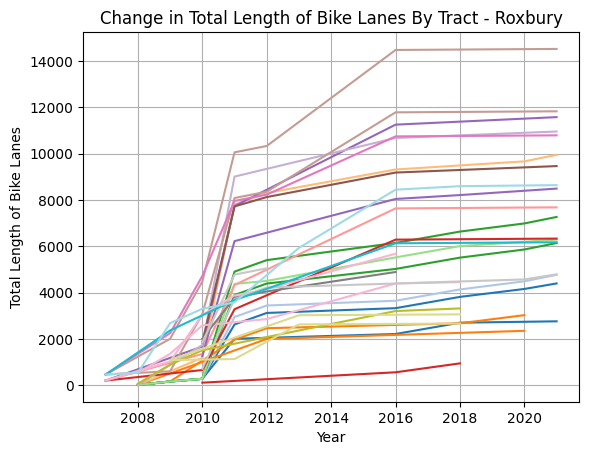

In [364]:
import matplotlib.pyplot as plt
rox_pivot['year'] = np.where(rox_pivot['year']==0, 2007,rox_pivot['year']) # replacing 0 with earliest year -1 (2007)
rox_pivot_sorted = rox_pivot.sort_values(by=['TRACTCE20', 'year']) #sorting by year to sum cummulatively

rox_pivot_sorted['cumulative_length'] = rox_pivot_sorted.groupby('TRACTCE20')['total_built'].cumsum(axis=0)

# Assuming rox_pivot contains the data with columns 'polygon_id', 'year', and total lengths of bike lanes
unique_polygon_ids = rox_pivot_sorted['TRACTCE20'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_polygon_ids)))

# Iterate through unique polygon IDs and plot a line for each polygon
for i, polygon_id in enumerate(rox_pivot_sorted['TRACTCE20'].unique()):
    polygon_data = rox_pivot_sorted[rox_pivot_sorted['TRACTCE20'] == polygon_id]
    plt.plot(polygon_data['year'], polygon_data['cumulative_length'], label=f'Polygon ID {polygon_id}', color=colors[i])

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Total Length of Bike Lanes')
plt.title('Change in Total Length of Bike Lanes By Tract - Roxbury')
# plt.legend(loc='best')  # Display legend for the lines
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot


In [367]:
# Streets with most bike lanes
street_df = roxbury_bike.loc[roxbury_bike['STREET_NAM']!=' ']
total_length_df = street_df.groupby(['STREET_NAM'])['Shape_Leng'].sum().reset_index()
total_length_df.rename(columns={'Shape_Leng': 'Total_Length'}, inplace=True)
total_length_df.sort_values(by='Total_Length',ascending=False,inplace=True)
top_5_streets = total_length_df.head(5)
top_5_streets.STREET_NAM.to_list()

['Warren Street',
 'Washington Street',
 'Seaver Street',
 'Morton Street',
 'Martin Luther King Boulevard']

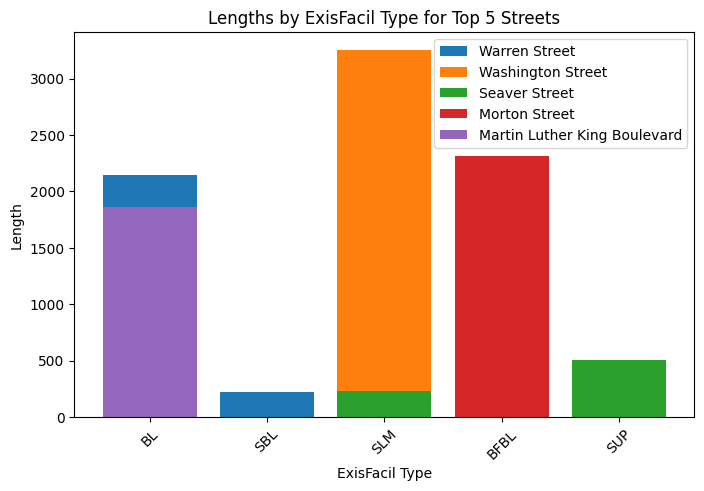

In [368]:
# length by street, for each facility type

data_dict = {}

for street in top_5_streets['STREET_NAM']:
    street_data = street_df.loc[street_df['STREET_NAM'] == street]
    lengths_by_type = street_data.groupby('ExisFacil')['Shape_Leng'].sum().reset_index()
    data_dict[street] = dict(zip(lengths_by_type['ExisFacil'], lengths_by_type['Shape_Leng']))

# Create a single plot with each street on the x-axis and different facility types as bars
plt.figure(figsize=(8, 5))
for street, data in data_dict.items():
    plt.bar(data.keys(), data.values(), label=street)

plt.xlabel('ExisFacil Type')
plt.ylabel('Length')
plt.title('Lengths by ExisFacil Type for Top 5 Streets')
plt.xticks(rotation=45)
plt.legend()
plt.show()


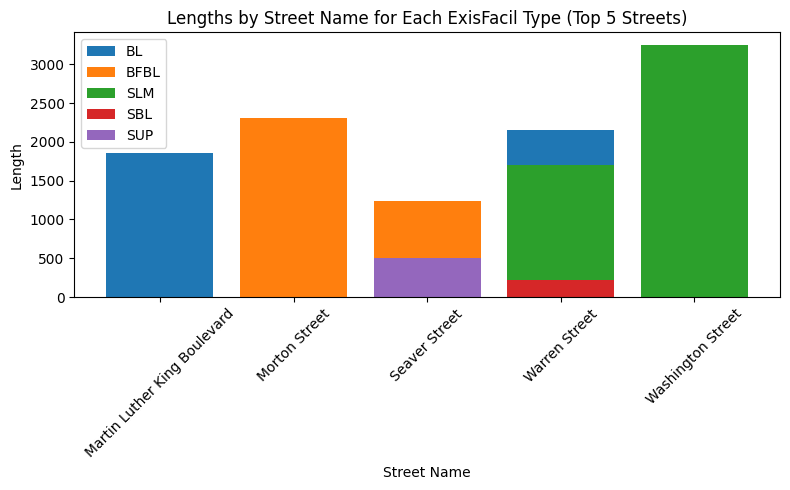

In [369]:
# length by facility type, for each street
data_dict = {}
color_dict = {}
# Populate the dictionary with lengths by Street name for each facility type for the top 5 streets
for facility_type in street_df['ExisFacil'].unique():
    facility_data = street_df.loc[(street_df['ExisFacil'] == facility_type) & (street_df['STREET_NAM'].isin(top_5_streets['STREET_NAM'].tolist()))]
    lengths_by_street = facility_data.groupby('STREET_NAM')['Shape_Leng'].sum().reset_index()
    data_dict[facility_type] = dict(zip(lengths_by_street['STREET_NAM'], lengths_by_street['Shape_Leng']))

unique_facility_types = data_dict.keys()
plt.figure(figsize=(8, 5))
for facility_type, data in data_dict.items():
    # color = color_dict[facility_type]  # Get color for the current facility type
    if data:
        plt.bar(data.keys(), data.values(), label=facility_type)

plt.xlabel('Street Name')
plt.ylabel('Length')
plt.title('Lengths by Street Name for Each ExisFacil Type (Top 5 Streets)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [370]:
# # total m of lanes by year and type
# yealy_new_lanes = roxbury_gdf.groupby(['year', 'ExisFacil'])['Shape_Leng'].sum().unstack()
# fig, ax = plt.subplots(figsize=(12, 6))
# yealy_new_lanes.plot(kind='bar', ax=ax, align='center', width=1)
# ax.set_xlabel('Year')
# ax.set_ylabel('Total Length of Lanes Built (m)')
# ax.set_title('Bike Lanes by Year & Type\nDorchester')
# ax.tick_params(axis='x', rotation=45)
# plt.show()

### merge

In [393]:
all_tracts = pd.concat((rox_pivot_sorted, dorch_pivot_sorted),ignore_index=True)
all_tracts

ExisFacil,TRACTCE20,year,BFBL,BL,BLSL,SBL,SLM,SUP,total_built,cumulative_length,SLMTC
0,010405,2008,0.0,0.000000,0.0,0.000000,17.649551,0.0,17.649551,17.649551,NaN
1,010405,2009,0.0,148.433979,0.0,0.000000,0.000000,0.0,148.433979,166.083529,NaN
2,010405,2010,0.0,0.000000,0.0,0.000000,115.331108,0.0,115.331108,281.414638,NaN
3,010405,2011,0.0,202.624744,0.0,0.000000,1524.555269,0.0,1727.180013,2008.594651,NaN
4,010405,2016,0.0,0.000000,0.0,0.000000,205.672671,0.0,205.672671,2214.267322,NaN
...,...,...,...,...,...,...,...,...,...,...,...
389,980300,2008,0.0,0.000000,0.0,0.000000,519.149110,0.0,519.149110,519.149110,0.0
390,980300,2009,0.0,421.943879,0.0,0.000000,0.000000,0.0,421.943879,941.092990,0.0
391,980300,2010,0.0,716.525320,0.0,0.000000,304.687031,0.0,1021.212351,1962.305341,0.0
392,980300,2012,0.0,738.194669,0.0,0.000000,1951.280027,0.0,2689.474696,4651.780037,0.0
